In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


# Adding all imports we need

In [2]:
import torch
from sklearn.model_selection import train_test_split
import re


import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

import itertools
from sklearn.metrics import confusion_matrix

# Reading all data and getting ready to work on them 

In [3]:
# Read train and test data
train = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')


**Split train data into train and validation sets**

In [4]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

train_sentences, train_targets = train_data['question_text'], train_data['target']
val_sentences, val_targets = val_data['question_text'], val_data['target']

In [5]:
train_data.head()

,qid,question_text,target
298773,3a820a95342d28ad402f,How is strategic positioning is different from...,0
815475,9fca299caa0cf8f12eac,What is the best way for promote Facebook mark...,0
1133453,de23f10ad011a6fb13c7,How much energized proton radiation does the I...,0
1076426,d2eef16340896e963a63,Would any Indian men want to marry a women tha...,0
203792,27d584db9bd46b6ab44e,Which is the best business for startups in Ind...,0


In [6]:
# Lets see distribution of sentensec in both train and validation sets
train_targets.value_counts(), val_targets.value_counts()

(0    979943
 1     64954
 Name: target, dtype: int64,
 0    245369
 1     15856
 Name: target, dtype: int64)

**This part of code is for prepoccess given data as much as we can**

In [7]:
# PREPROCCESING

contractions={"I'm": 'I am',
 "I'm'a": 'I am about to',
 "I'm'o": 'I am going to',
 "I've": 'I have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'd": 'I would',
 "I'd've": 'I would have',
 'Whatcha': 'What are you',
 "amn't": 'am not',
 "ain't": 'are not',
 "aren't": 'are not',
 "'cause": 'because',
 "can't": 'can not',
 "can't've": 'can not have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "daren't": 'dare not',
 "daresn't": 'dare not',
 "dasn't": 'dare not',
 "didn't": 'did not',
 'didn’t': 'did not',
 "don't": 'do not',
 'don’t': 'do not',
 "doesn't": 'does not',
 "e'er": 'ever',
 "everyone's": 'everyone is',
 'finna': 'fixing to',
 'gimme': 'give me',
 "gon't": 'go not',
 'gonna': 'going to',
 'gotta': 'got to',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he've": 'he have',
 "he's": 'he is',
 "he'll": 'he will',
 "he'll've": 'he will have',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "here's": 'here is',
 "how're": 'how are',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how's": 'how is',
 "how'll": 'how will',
 "isn't": 'is not',
 "it's": 'it is',
 "'tis": 'it is',
 "'twas": 'it was',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it'd": 'it would',
 "it'd've": 'it would have',
 'kinda': 'kind of',
 "let's": 'let us',
 'luv': 'love',
 "ma'am": 'madam',
 "may've": 'may have',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "ne'er": 'never',
 "o'": 'of',
 "o'clock": 'of the clock',
 "ol'": 'old',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "o'er": 'over',
 "shan't": 'shall not',
 "sha'n't": 'shall not',
 "shalln't": 'shall not',
 "shan't've": 'shall not have',
 "she's": 'she is',
 "she'll": 'she will',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',
 "so've": 'so have',
 "so's": 'so is',
 "somebody's": 'somebody is',
 "someone's": 'someone is',
 "something's": 'something is',
 'sux': 'sucks',
 "that're": 'that are',
 "that's": 'that is',
 "that'll": 'that will',
 "that'd": 'that would',
 "that'd've": 'that would have',
 'em': 'them',
 "there're": 'there are',
 "there's": 'there is',
 "there'll": 'there will',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "these're": 'these are',
 "they're": 'they are',
 "they've": 'they have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "this's": 'this is',
 "those're": 'those are',
 "to've": 'to have',
 'wanna': 'want to',
 "wasn't": 'was not',
 "we're": 'we are',
 "we've": 'we have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "weren't": 'were not',
 "what're": 'what are',
 "what'd": 'what did',
 "what've": 'what have',
 "what's": 'what is',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "when've": 'when have',
 "when's": 'when is',
 "where're": 'where are',
 "where'd": 'where did',
 "where've": 'where have',
 "where's": 'where is',
 "which's": 'which is',
 "who're": 'who are',
 "who've": 'who have',
 "who's": 'who is',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who'd": 'who would',
 "who'd've": 'who would have',
 "why're": 'why are',
 "why'd": 'why did',
 "why've": 'why have',
 "why's": 'why is',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "you're": 'you are',
 "you've": 'you have',
 "you'll've": 'you shall have',
 "you'll": 'you will',
 "you'd": 'you would',
 "you'd've": 'you would have',
 'jan.': 'january',
 'feb.': 'february',
 'mar.': 'march',
 'apr.': 'april',
 'jun.': 'june',
 'jul.': 'july',
 'aug.': 'august',
 'sep.': 'september',
 'oct.': 'october',
 'nov.': 'november',
 'dec.': 'december',
 'I’m': 'I am',
 'I’m’a': 'I am about to',
 'I’m’o': 'I am going to',
 'I’ve': 'I have',
 'I’ll': 'I will',
 'I’ll’ve': 'I will have',
 'I’d': 'I would',
 'I’d’ve': 'I would have',
 'amn’t': 'am not',
 'ain’t': 'are not',
 'aren’t': 'are not',
 '’cause': 'because',
 'can’t': 'can not',
 'can’t’ve': 'can not have',
 'could’ve': 'could have',
 'couldn’t': 'could not',
 'couldn’t’ve': 'could not have',
 'daren’t': 'dare not',
 'daresn’t': 'dare not',
 'dasn’t': 'dare not',
 'doesn’t': 'does not',
 'e’er': 'ever',
 'everyone’s': 'everyone is',
 'gon’t': 'go not',
 'hadn’t': 'had not',
 'hadn’t’ve': 'had not have',
 'hasn’t': 'has not',
 'haven’t': 'have not',
 'he’ve': 'he have',
 'he’s': 'he is',
 'he’ll': 'he will',
 'he’ll’ve': 'he will have',
 'he’d': 'he would',
 'he’d’ve': 'he would have',
 'here’s': 'here is',
 'how’re': 'how are',
 'how’d': 'how did',
 'how’d’y': 'how do you',
 'how’s': 'how is',
 'how’ll': 'how will',
 'isn’t': 'is not',
 'it’s': 'it is',
 '’tis': 'it is',
 '’twas': 'it was',
 'it’ll': 'it will',
 'it’ll’ve': 'it will have',
 'it’d': 'it would',
 'it’d’ve': 'it would have',
 'let’s': 'let us',
 'ma’am': 'madam',
 'may’ve': 'may have',
 'mayn’t': 'may not',
 'might’ve': 'might have',
 'mightn’t': 'might not',
 'mightn’t’ve': 'might not have',
 'must’ve': 'must have',
 'mustn’t': 'must not',
 'mustn’t’ve': 'must not have',
 'needn’t': 'need not',
 'needn’t’ve': 'need not have',
 'ne’er': 'never',
 'o’': 'of',
 'o’clock': 'of the clock',
 'ol’': 'old',
 'oughtn’t': 'ought not',
 'oughtn’t’ve': 'ought not have',
 'o’er': 'over',
 'shan’t': 'shall not',
 'sha’n’t': 'shall not',
 'shalln’t': 'shall not',
 'shan’t’ve': 'shall not have',
 'she’s': 'she is',
 'she’ll': 'she will',
 'she’d': 'she would',
 'she’d’ve': 'she would have',
 'should’ve': 'should have',
 'shouldn’t': 'should not',
 'shouldn’t’ve': 'should not have',
 'so’ve': 'so have',
 'so’s': 'so is',
 'somebody’s': 'somebody is',
 'someone’s': 'someone is',
 'something’s': 'something is',
 'that’re': 'that are',
 'that’s': 'that is',
 'that’ll': 'that will',
 'that’d': 'that would',
 'that’d’ve': 'that would have',
 'there’re': 'there are',
 'there’s': 'there is',
 'there’ll': 'there will',
 'there’d': 'there would',
 'there’d’ve': 'there would have',
 'these’re': 'these are',
 'they’re': 'they are',
 'they’ve': 'they have',
 'they’ll': 'they will',
 'they’ll’ve': 'they will have',
 'they’d': 'they would',
 'they’d’ve': 'they would have',
 'this’s': 'this is',
 'those’re': 'those are',
 'to’ve': 'to have',
 'wasn’t': 'was not',
 'we’re': 'we are',
 'we’ve': 'we have',
 'we’ll': 'we will',
 'we’ll’ve': 'we will have',
 'we’d': 'we would',
 'we’d’ve': 'we would have',
 'weren’t': 'were not',
 'what’re': 'what are',
 'what’d': 'what did',
 'what’ve': 'what have',
 'what’s': 'what is',
 'what’ll': 'what will',
 'what’ll’ve': 'what will have',
 'when’ve': 'when have',
 'when’s': 'when is',
 'where’re': 'where are',
 'where’d': 'where did',
 'where’ve': 'where have',
 'where’s': 'where is',
 'which’s': 'which is',
 'who’re': 'who are',
 'who’ve': 'who have',
 'who’s': 'who is',
 'who’ll': 'who will',
 'who’ll’ve': 'who will have',
 'who’d': 'who would',
 'who’d’ve': 'who would have',
 'why’re': 'why are',
 'why’d': 'why did',
 'why’ve': 'why have',
 'why’s': 'why is',
 'will’ve': 'will have',
 'won’t': 'will not',
 'won’t’ve': 'will not have',
 'would’ve': 'would have',
 'wouldn’t': 'would not',
 'wouldn’t’ve': 'would not have',
 'y’all': 'you all',
 'y’all’re': 'you all are',
 'y’all’ve': 'you all have',
 'y’all’d': 'you all would',
 'y’all’d’ve': 'you all would have',
 'you’re': 'you are',
 'you’ve': 'you have',
 'you’ll’ve': 'you shall have',
 'you’ll': 'you will',
 'you’d': 'you would',
 'you’d’ve': 'you would have'}

In [8]:
def contraction_fix(word):
    try:
        a=contractions[word]
    except KeyError:
        a=word
    return a

In [9]:
#This method fixes contractions and removes digits
def preprocess(sentences):
    processed=[] 
    for text in sentences:
        text=" ".join([contraction_fix(w) for w in text.split()])
        text=re.sub(r'[^a-z0-9A-Z]'," ",text) 
        text=re.sub(r'[0-9]{1}',"#",text) 
        text=re.sub(r'[0-9]{2}','##',text)  
        text=re.sub(r'[0-9]{3}','###',text)
        text=re.sub(r'[0-9]{4}','####',text)
        text=re.sub(r'[0-9]{5,}','#####',text)
        processed.append(text)
    return processed

# Preprocess the sentences(remove digits, fix contractions and etc.)

In [10]:
train_sentences = preprocess(train_sentences)

# Counting each words frequency and indexing them

In [11]:
#Building vocabulary (in lower case)

def vocab_build(sentences):
    words={}
    for text in sentences:
        for word in text.split():
            word = word.lower()
            try:
                words[word]+=1
            except KeyError:
                words[word]=1
    return words

def get_word_index(vocab):
    word_index=dict((w,i+1) for i,w in enumerate(vocab.keys()))
    return word_index

words = vocab_build(train_sentences)
vocab = get_word_index(words)


# Lets see diagram of sentence lengths

In [12]:
# Helper function to count words in sentence

def word_count_in_sentence(sentence):
    return len(sentence.split())


(array([2.20000e+01, 5.00000e+01, 4.40000e+03, 1.69500e+04, 3.31870e+04,
        1.39025e+05, 9.55360e+04, 9.77040e+04, 9.25610e+04, 8.03530e+04,
        1.28703e+05, 4.94950e+04, 4.14750e+04, 3.47810e+04, 2.96060e+04,
        4.68040e+04, 1.87520e+04, 1.64430e+04, 1.43180e+04, 1.28140e+04,
        2.15740e+04, 9.19500e+03, 7.73700e+03, 6.90000e+03, 5.80200e+03,
        9.06400e+03, 3.61200e+03, 3.03800e+03, 2.72200e+03, 2.44200e+03,
        4.39500e+03, 1.92700e+03, 1.87400e+03, 1.75400e+03, 1.66100e+03,
        2.80500e+03, 1.03200e+03, 9.37000e+02, 8.10000e+02, 5.92000e+02,
        9.64000e+02, 3.17000e+02, 2.54000e+02, 1.83000e+02, 9.80000e+01,
        1.39000e+02, 3.80000e+01, 2.00000e+01, 7.00000e+00, 1.70000e+01]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ,
        13.2, 14.4, 15.6, 16.8, 18. , 19.2, 20.4, 21.6, 22.8, 24. , 25.2,
        26.4, 27.6, 28.8, 30. , 31.2, 32.4, 33.6, 34.8, 36. , 37.2, 38.4,
        39.6, 40.8, 42. , 43.2, 44.4, 45.6, 46

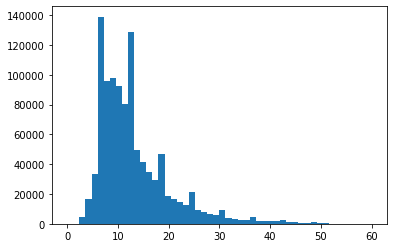

In [13]:
question_lens = [word_count_in_sentence(sentence) for sentence in train_sentences]

plt.hist(question_lens, range=(0,60), bins=50)

# Based on the diagram we can take avarage lengths of sentences

In [14]:
AVG_MIN_LENGTH = 5 
AVG_MAX_LENGTH = 20 
AVG_LENGTH = 13

# We can see distribution of 1s and 0s in the train set

<AxesSubplot:title={'center':'Target categories'}, ylabel='target'>

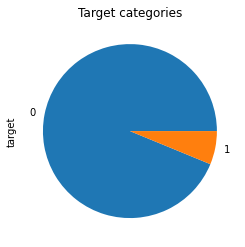

In [15]:
train_targets.value_counts().plot(title='Target categories',kind='pie')

**Could not use this code because it took too much space. Had to write in another way**

In [16]:
# unzip the embeddings folder 

# !unzip ../input/quora-insincere-questions-classification/embeddings.zip

# file_name="glove.840B.300d/glove.840B.300d.txt"
# word2vecs = {}
# file = open(file_name, "r")
# word2vec = file.read().split(' ')
# word2vecs[word2vec[0]] = np.asarray(word2vec[1:], dtype='float32')

**Another way is to unzip only when needed and not allocating all memory**
*This takes few minutes*

In [17]:
from zipfile import ZipFile 

word2vecs = {}
file_name="glove.840B.300d/glove.840B.300d.txt"
with ZipFile('/kaggle/input/quora-insincere-questions-classification/embeddings.zip') as zip_file:
    for embedding in zip_file.open(file_name, 'r'):
        word2vec = embedding.decode().split(' ')
        word2vecs[word2vec[0]] = np.asarray(word2vec[1:], dtype='float32')


# Defining some constants for batch size and epochs

In [18]:
BATCH_SIZE = 256
BATCHES = (len(train_sentences)+BATCH_SIZE-1)//BATCH_SIZE
EPOCHS = 2
EMBD_SIZE = 300
HIDDEN_SIZE = 30

In [19]:
# Function to replace each word with its embedding vector

def configure_word2vecs(sentences, word2vecs):
    def configure_sentence(sentence, len=HIDDEN_SIZE):
        return ([word2vecs.get(word.lower(), np.zeros(EMBD_SIZE)) for word in sentence.split()] + [np.zeros(EMBD_SIZE)]*len)[:len] 
    
    return [configure_sentence(sentence) for sentence in sentences]

# Main neural network code

In [20]:
class ClassifierModel(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
                
        self.emb = nn.LSTM(EMBD_SIZE, HIDDEN_SIZE, 1, batch_first=True)
        self.lin = nn.Linear(HIDDEN_SIZE, 1)
        
        
    def forward(self, src):
        outputs, (hidden, cell) = self.emb(src)
        return self.lin(hidden.reshape(-1, HIDDEN_SIZE))

# Creating model, loss function and optimizer

In [21]:
model = ClassifierModel()

calc_loss = nn.BCEWithLogitsLoss()

# define optimizer - algorithm used for optimizing loss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Confusion Matrix Code

In [22]:
# might use confusion_matrix plot for better visualisation and seeing the progress of the model

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Evaluates accuracy

In [23]:
def calc_accuracy(y_pred, y_test, batch):
    y_pred = torch.round(torch.sigmoid(y_pred))
    correct = (y_pred == y_test).sum().float()
    
#  if we use this code it will plot confusion_matrixes, but it prints too many graphics...

    if (batch+1) % 500 == 0:
    
        cnf_matrix = confusion_matrix(y_test.detach().numpy(), y_pred.detach().numpy())
        plt.figure(figsize=(5, 5))
        plot_confusion_matrix(cnf_matrix, 
                                classes=['Neg', 'Pos'],
                                title='Confusion Matrix')

        plt.show()
    return torch.round(100*(correct/y_pred.shape[0]))

# Torch tensor according to the data

In [24]:
def get_batch(idx):
    embd_vecs = configure_word2vecs(train_sentences[BATCH_SIZE*idx:BATCH_SIZE*(idx+1)], word2vecs)
    target = np.asarray(train_targets[BATCH_SIZE*idx:BATCH_SIZE*(idx+1)], dtype='bool')
    return torch.FloatTensor(embd_vecs), torch.FloatTensor(target)

# Train the model and use validation sets

In [25]:
model.train()

VALIDATION_BATCHES = 10

#replace each word with its embedding vector
val_word2vecs = configure_word2vecs(val_sentences[:VALIDATION_BATCHES*BATCH_SIZE], word2vecs)
val_targs = np.asarray(val_targets[:VALIDATION_BATCHES*BATCH_SIZE], dtype='bool')

#get tensors for validation data
val_batch = torch.FloatTensor(val_word2vecs)
val_target = torch.FloatTensor(val_targs)

# Method to train batches with updating epoch loss and epoch accuracy

In [26]:
def train_batches(epoch):
    epoch_loss, epoch_acc = 0, 0
    
    for batch in range(BATCHES):
        X_batch, y_batch = get_batch(batch)
        
        # this needs to be runned before doing gradient step. PyTorch by default accumulates previous gradients from previous steps so we need to tell it to clear everything.
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X_batch)
        
        # loss computation
        loss = calc_loss(y_pred, y_batch.unsqueeze(1))
        
        val_pred = model(val_batch)
        acc = calc_accuracy(val_pred, val_target.unsqueeze(1),batch)

        # running backpropagation algorithm (computing loss gradients with respect to neural network weights)
        loss.backward()
        
        # doing SGD step and updating neural network weights
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        if batch == 0 or (batch+1) % 100 == 0:
            print(f'Epoch {(epoch+1)+0:03} | Batch {(batch+1)+0:04}: | Loss: {epoch_loss/(batch+1):.5f} | Acc: {epoch_acc/(batch+1):.3f} ')
    return epoch_loss, epoch_acc 

# Main method for model training, calls train_batches method
*This might need quite some time - up to 1-2 hours*

Epoch 001 | Batch 0001: | Loss: 0.70251 | Acc: 8.000 
Epoch 001 | Batch 0100: | Loss: 0.39614 | Acc: 90.570 
Epoch 001 | Batch 0200: | Loss: 0.30556 | Acc: 92.285 
Epoch 001 | Batch 0300: | Loss: 0.25641 | Acc: 92.857 
Epoch 001 | Batch 0400: | Loss: 0.22565 | Acc: 93.142 
Confusion matrix, without normalization


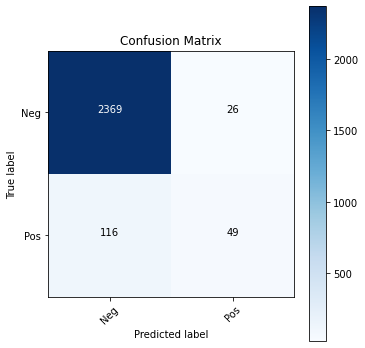

Epoch 001 | Batch 0500: | Loss: 0.20604 | Acc: 93.314 
Epoch 001 | Batch 0600: | Loss: 0.19305 | Acc: 93.458 
Epoch 001 | Batch 0700: | Loss: 0.18368 | Acc: 93.573 
Epoch 001 | Batch 0800: | Loss: 0.17699 | Acc: 93.654 
Epoch 001 | Batch 0900: | Loss: 0.17134 | Acc: 93.729 
Confusion matrix, without normalization


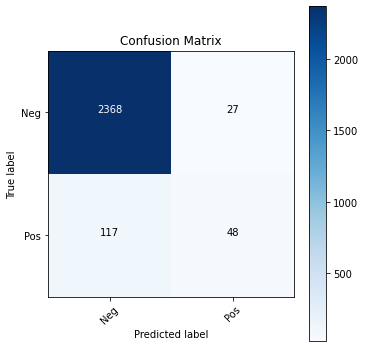

Epoch 001 | Batch 1000: | Loss: 0.16638 | Acc: 93.810 
Epoch 001 | Batch 1100: | Loss: 0.16252 | Acc: 93.880 
Epoch 001 | Batch 1200: | Loss: 0.15933 | Acc: 93.933 
Epoch 001 | Batch 1300: | Loss: 0.15653 | Acc: 93.999 
Epoch 001 | Batch 1400: | Loss: 0.15376 | Acc: 94.066 
Confusion matrix, without normalization


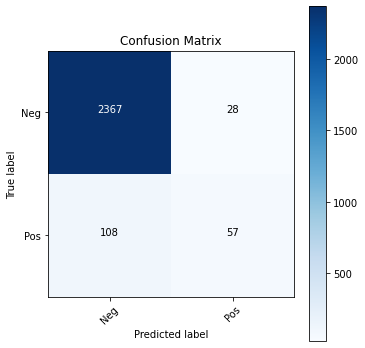

Epoch 001 | Batch 1500: | Loss: 0.15128 | Acc: 94.097 
Epoch 001 | Batch 1600: | Loss: 0.14915 | Acc: 94.134 
Epoch 001 | Batch 1700: | Loss: 0.14729 | Acc: 94.172 
Epoch 001 | Batch 1800: | Loss: 0.14537 | Acc: 94.200 
Epoch 001 | Batch 1900: | Loss: 0.14388 | Acc: 94.231 
Confusion matrix, without normalization


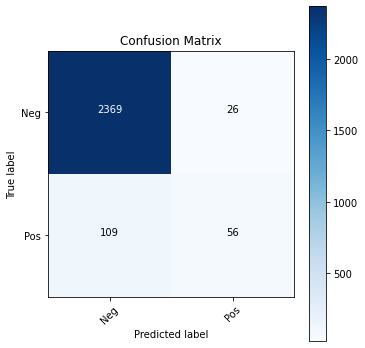

Epoch 001 | Batch 2000: | Loss: 0.14245 | Acc: 94.255 
Epoch 001 | Batch 2100: | Loss: 0.14112 | Acc: 94.277 
Epoch 001 | Batch 2200: | Loss: 0.13984 | Acc: 94.300 
Epoch 001 | Batch 2300: | Loss: 0.13870 | Acc: 94.323 
Epoch 001 | Batch 2400: | Loss: 0.13747 | Acc: 94.339 
Confusion matrix, without normalization


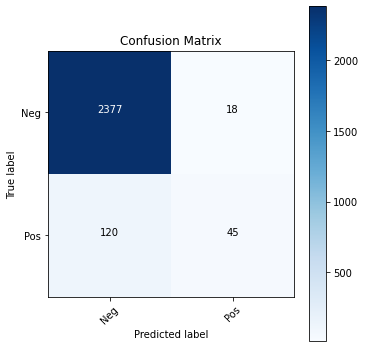

Epoch 001 | Batch 2500: | Loss: 0.13656 | Acc: 94.361 
Epoch 001 | Batch 2600: | Loss: 0.13554 | Acc: 94.373 
Epoch 001 | Batch 2700: | Loss: 0.13483 | Acc: 94.387 
Epoch 001 | Batch 2800: | Loss: 0.13390 | Acc: 94.406 
Epoch 001 | Batch 2900: | Loss: 0.13324 | Acc: 94.427 
Confusion matrix, without normalization


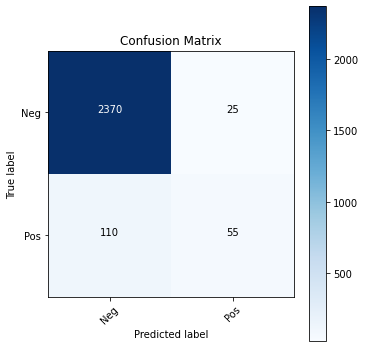

Epoch 001 | Batch 3000: | Loss: 0.13258 | Acc: 94.444 
Epoch 001 | Batch 3100: | Loss: 0.13197 | Acc: 94.459 
Epoch 001 | Batch 3200: | Loss: 0.13134 | Acc: 94.476 
Epoch 001 | Batch 3300: | Loss: 0.13082 | Acc: 94.492 
Epoch 001 | Batch 3400: | Loss: 0.13032 | Acc: 94.506 
Confusion matrix, without normalization


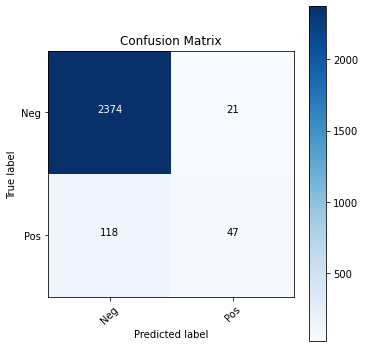

Epoch 001 | Batch 3500: | Loss: 0.12977 | Acc: 94.520 
Epoch 001 | Batch 3600: | Loss: 0.12927 | Acc: 94.533 
Epoch 001 | Batch 3700: | Loss: 0.12887 | Acc: 94.544 
Epoch 001 | Batch 3800: | Loss: 0.12840 | Acc: 94.554 
Epoch 001 | Batch 3900: | Loss: 0.12797 | Acc: 94.564 
Confusion matrix, without normalization


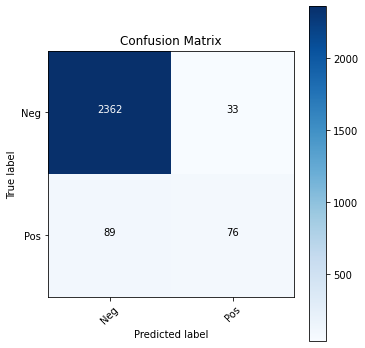

Epoch 001 | Batch 4000: | Loss: 0.12747 | Acc: 94.575 
Epoch 001: | Epoch Loss: 0.12712 | Epoch Acc: 94.582
Epoch 002 | Batch 0001: | Loss: 0.10385 | Acc: 95.000 
Epoch 002 | Batch 0100: | Loss: 0.10678 | Acc: 94.930 
Epoch 002 | Batch 0200: | Loss: 0.10754 | Acc: 94.965 
Epoch 002 | Batch 0300: | Loss: 0.10823 | Acc: 94.977 
Epoch 002 | Batch 0400: | Loss: 0.10760 | Acc: 94.965 
Confusion matrix, without normalization


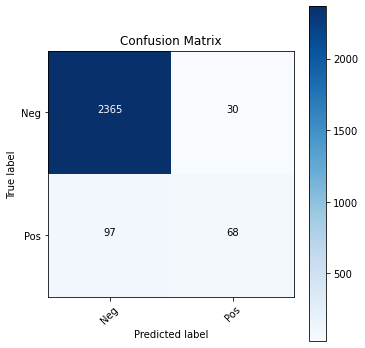

Epoch 002 | Batch 0500: | Loss: 0.10683 | Acc: 94.962 
Epoch 002 | Batch 0600: | Loss: 0.10714 | Acc: 94.968 
Epoch 002 | Batch 0700: | Loss: 0.10762 | Acc: 94.973 
Epoch 002 | Batch 0800: | Loss: 0.10817 | Acc: 94.976 
Epoch 002 | Batch 0900: | Loss: 0.10832 | Acc: 94.979 
Confusion matrix, without normalization


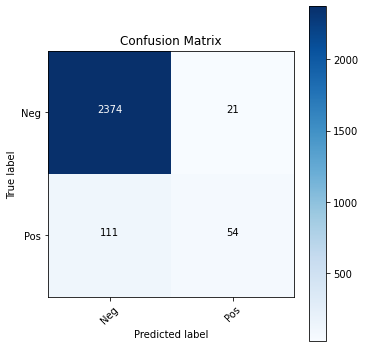

Epoch 002 | Batch 1000: | Loss: 0.10811 | Acc: 94.979 
Epoch 002 | Batch 1100: | Loss: 0.10819 | Acc: 94.980 
Epoch 002 | Batch 1200: | Loss: 0.10839 | Acc: 94.978 
Epoch 002 | Batch 1300: | Loss: 0.10844 | Acc: 94.976 
Epoch 002 | Batch 1400: | Loss: 0.10817 | Acc: 94.978 
Confusion matrix, without normalization


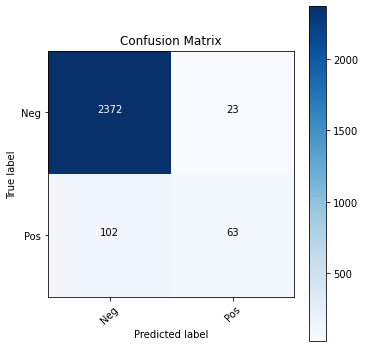

Epoch 002 | Batch 1500: | Loss: 0.10798 | Acc: 94.979 
Epoch 002 | Batch 1600: | Loss: 0.10783 | Acc: 94.979 
Epoch 002 | Batch 1700: | Loss: 0.10784 | Acc: 94.980 
Epoch 002 | Batch 1800: | Loss: 0.10751 | Acc: 94.981 
Epoch 002 | Batch 1900: | Loss: 0.10741 | Acc: 94.982 
Confusion matrix, without normalization


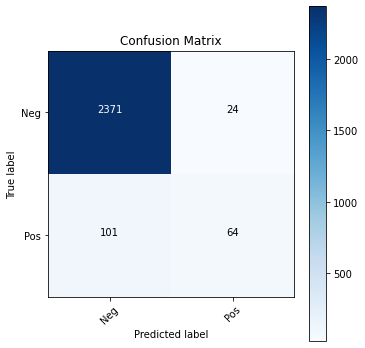

Epoch 002 | Batch 2000: | Loss: 0.10739 | Acc: 94.983 
Epoch 002 | Batch 2100: | Loss: 0.10725 | Acc: 94.983 
Epoch 002 | Batch 2200: | Loss: 0.10707 | Acc: 94.984 
Epoch 002 | Batch 2300: | Loss: 0.10698 | Acc: 94.984 
Epoch 002 | Batch 2400: | Loss: 0.10674 | Acc: 94.983 
Confusion matrix, without normalization


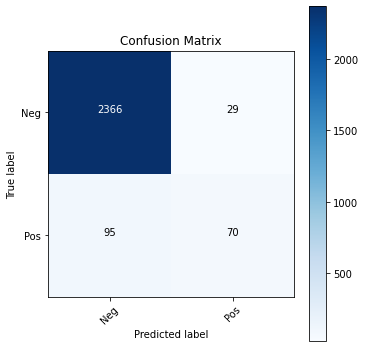

Epoch 002 | Batch 2500: | Loss: 0.10673 | Acc: 94.984 
Epoch 002 | Batch 2600: | Loss: 0.10654 | Acc: 94.983 
Epoch 002 | Batch 2700: | Loss: 0.10661 | Acc: 94.983 
Epoch 002 | Batch 2800: | Loss: 0.10639 | Acc: 94.984 
Epoch 002 | Batch 2900: | Loss: 0.10641 | Acc: 94.984 
Confusion matrix, without normalization


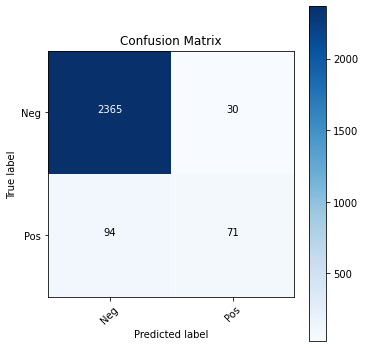

Epoch 002 | Batch 3000: | Loss: 0.10640 | Acc: 94.985 
Epoch 002 | Batch 3100: | Loss: 0.10641 | Acc: 94.985 
Epoch 002 | Batch 3200: | Loss: 0.10634 | Acc: 94.986 
Epoch 002 | Batch 3300: | Loss: 0.10634 | Acc: 94.986 
Epoch 002 | Batch 3400: | Loss: 0.10636 | Acc: 94.987 
Confusion matrix, without normalization


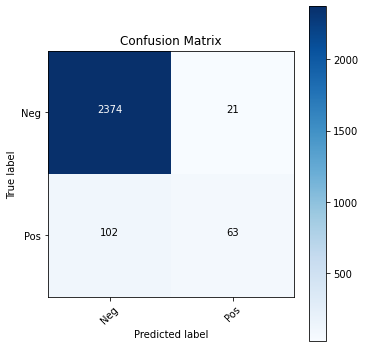

Epoch 002 | Batch 3500: | Loss: 0.10629 | Acc: 94.987 
Epoch 002 | Batch 3600: | Loss: 0.10626 | Acc: 94.987 
Epoch 002 | Batch 3700: | Loss: 0.10630 | Acc: 94.988 
Epoch 002 | Batch 3800: | Loss: 0.10625 | Acc: 94.988 
Epoch 002 | Batch 3900: | Loss: 0.10620 | Acc: 94.989 
Confusion matrix, without normalization


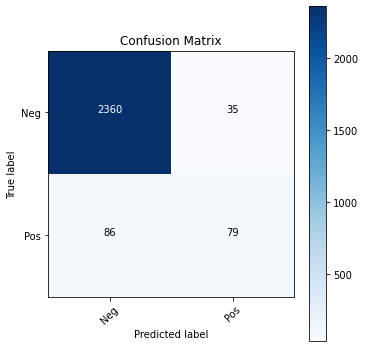

Epoch 002 | Batch 4000: | Loss: 0.10610 | Acc: 94.990 
Epoch 002: | Epoch Loss: 0.10606 | Epoch Acc: 94.990


In [27]:
def train_loop():
    for epoch in range(EPOCHS):

        epoch_loss, epoch_acc = train_batches(epoch)

        print(f'Epoch {(epoch+1)+0:03}: | Epoch Loss: {epoch_loss/BATCHES:.5f} | Epoch Acc: {epoch_acc/BATCHES:.3f}')
        
train_loop()        

In [28]:
test_sentences, test_targets = test['question_text'], []
TEST_BATCHES = (len(test_sentences)+BATCH_SIZE-1)//BATCH_SIZE

# Lets work our model on test data 

In [29]:
model.eval()
with torch.no_grad():
    for b in range(TEST_BATCHES):
      
        X_batch = torch.FloatTensor(configure_word2vecs(test_sentences[BATCH_SIZE*b:BATCH_SIZE*(b+1)], word2vecs))
        
        trg = torch.round(torch.sigmoid(model(X_batch))).cpu().numpy().squeeze()
        test_targets.extend(trg)
        
        if (b+1) % 100 == 0: print('Predicting...')

Predicting...
Predicting...
Predicting...
Predicting...
Predicting...
Predicting...
Predicting...
Predicting...
Predicting...
Predicting...
Predicting...
Predicting...
Predicting...
Predicting...


# Now write predicted data into submission.csv

In [30]:
test_targets = (np.array(test_targets) >= 0.5).astype(np.int)
result = pd.DataFrame({"qid": test['qid'], "prediction": test_targets})
result.to_csv("submission.csv", index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


# Here we will see the distribution of 1s and 0s of predicted values

In [31]:
result.prediction.value_counts()

0    362095
1     13711
Name: prediction, dtype: int64

# Lets see how our model predicted answers on test set

In [32]:
print("Below are 5 sentences that are predicted to be 'good': \n")
counter = 0
for i, sentence in enumerate(test_sentences):
        sent_len = len(sentence.split(' '))
        if AVG_MIN_LENGTH <= sent_len and sent_len <= AVG_MAX_LENGTH:
            if test_targets[i] == 0:
                counter += 1
                print(sentence)
                if counter >= 5: break

Below are 5 sentences that are predicted to be 'good': 

What is it really like to be a nurse practitioner?
Is education really making good people nowadays?
How do you train a pigeon to send messages?
What is the currency in Langkawi?
What is the future for Pandora, can the business reduce its debt?


In [33]:
print("Below are 5 sentences that are predicted to be 'bad': \n")
counter = 0
for i, sentence in enumerate(test_sentences):
        sent_len = len(sentence.split(' '))
        if AVG_MIN_LENGTH <= sent_len and sent_len <= AVG_MAX_LENGTH:
            if test_targets[i] == 1:
                counter += 1
                print(sentence)
                if counter >= 5: break

Below are 5 sentences that are predicted to be 'bad': 

Why most Telugu and Marathi Muslims speak Urdu and are ashamed of their native languages?
Why do Bengali and Kolkata people dominate Hindi language speaking people from Delhi, Mumbai and other parts of India?
Why do Indian girls look for only NRI boys for marriage?
Why do Asian people hate white and black people? (READ COMMENT)
Should a child of incest be told the truth?
